# Agent implementation

`````{margin}
````{dropdown} Necessary imports
```{code-block} python
import re
from typing import Union, Dict, Any, Callable

import dm_env
import gin
import numpy as np
from ray import tune
from matplotlib import pyplot as plt, cm

from colosseum import config
from colosseum.agent.actors import QValuesActor
from colosseum.agent.agents.base import BaseAgent
from colosseum.agent.agents.episodic import QLearningEpisodic
from colosseum.agent.mdp_models.base import BaseMDPModel
from colosseum.analysis.plots import _get_index
from colosseum.analysis.plots import agent_performances_per_mdp_plot
from colosseum.analysis.plots import plot_labels_on_benchmarks_hardness_space
from colosseum.analysis.tables import get_latex_table_of_average_indicator
from colosseum.benchmark import ColosseumDefaultBenchmark
from colosseum.dynamic_programming.utils import get_policy_from_q_values
from colosseum.emission_maps import EmissionMap
from colosseum.experiment.agent_mdp_interaction import MDPLoop
from colosseum.hyperopt import SMALL_HYPEROPT_CONF
from colosseum.mdp.river_swim import RiverSwimEpisodic
from colosseum.utils import make_mdp_spec
from colosseum.utils.acme.specs import MDPSpec
from colosseum.utils.acme import InMemoryLogger
from colosseum.benchmark.run import instantiate_and_get_exp_instances_from_benchmark
from colosseum.experiment.experiment_instances import run_experiment_instances
from colosseum.agent.utils import sample_agent_gin_configs_file

seed = 42

config.set_experiments_folder("tutorial", "agent_run")
```
````
`````

In [1]:
import re
import shutil
from typing import Union, Dict, Any, Callable

import dm_env
import gin
import numpy as np
from ray import tune
from matplotlib import pyplot as plt, cm
from myst_nb import glue

from colosseum import config
from colosseum.agent.actors import QValuesActor
from colosseum.agent.agents.base import BaseAgent
from colosseum.agent.agents.episodic import QLearningEpisodic
from colosseum.agent.mdp_models.base import BaseMDPModel
from colosseum.analysis.plots import _get_index
from colosseum.analysis.plots import agent_performances_per_mdp_plot
from colosseum.analysis.plots import plot_labels_on_benchmarks_hardness_space
from colosseum.analysis.tables import get_latex_table_of_average_indicator
from colosseum.benchmark import ColosseumDefaultBenchmark
from colosseum.dynamic_programming.utils import get_policy_from_q_values
from colosseum.emission_maps import EmissionMap
from colosseum.experiment.agent_mdp_interaction import MDPLoop
from colosseum.hyperopt import SMALL_HYPEROPT_CONF
from colosseum.mdp.river_swim import RiverSwimEpisodic
from colosseum.utils import make_mdp_spec
from colosseum.utils.acme.specs import MDPSpec
from colosseum.utils.acme import InMemoryLogger
from colosseum.benchmark.run import instantiate_and_get_exp_instances_from_benchmark
from colosseum.experiment.experiment_instances import run_experiment_instances
from colosseum.agent.utils import sample_agent_gin_configs_file

seed = 42

config.set_experiments_folder("tutorial", "agent_run")

2022-10-15 16:36:09.691054: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-15 16:36:09.780984: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2022-10-15 16:36:10.127973: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-15 16:36:10.128014: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-10-15 16:36:10.128018: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


This tutorial covers the implementation of a new agent in {{col}}.
Although novel agents should be preferably implemented inside the
[`agents`](../pdoc_files/colosseum/agent/agents.html)
module, it is also possible to implement your agent outside {{col}} and register the implemented class to {{col}}.
For the sake of the tutorial, we will follow the latter option.

Before diving into the tutorial, we list below the agent classes available in the package.

**Available agent classes**
::::{grid} 2
:gutter: 4

:::{grid-item-card} Tabular episodic agents
<a href="../pdoc_files/colosseum/agent/agents/episodic/posterior_sampling.html#PSRLEpisodic">``PSRLEpisodic``</a>  
<a href="../pdoc_files/colosseum/agent/agents/episodic/q_learning.html#QLearningEpisodic">``QLearningEpisodic``</a>  
:::

:::{grid-item-card} Tabular continuous  agents
<a href="../pdoc_files/colosseum/agent/agents/infinite_horizon/posterior_sampling.html#PSRLContinuous">``PSRLContinuous``</a>  
<a href="../pdoc_files/colosseum/agent/agents/infinite_horizon/q_learning.html#QLearningContinuous">``QLearningContinuous``</a>  
<a href="../pdoc_files/colosseum/agent/agents/infinite_horizon/ucrl2.html#UCRL2Continuous">``UCRL2Continuous``</a>
:::

:::{grid-item-card} Non-tabular episodic agents
<a href="../pdoc_files/colosseum/agent/agents/episodic/actor_critic.html#ActorCriticEpisodic">``ActorCriticEpisodic``</a>  
<a href="../pdoc_files/colosseum/agent/agents/episodic/actor_critic_rnn.html#ActorCriticRNNEpisodic">``ActorCriticRNNEpisodic``</a>  
<a href="../pdoc_files/colosseum/agent/agents/episodic/boot_dqn.html#BootDQNEpisodic">``BootDQNEpisodic``</a>  
<a href="../pdoc_files/colosseum/agent/agents/episodic/dqn.html#DQNEpisodic">``DQNEpisodic``</a>  
:::

:::{grid-item-card} Non-tabular continuous agents
<a href="../pdoc_files/colosseum/agent/agents/infinite_horizon/actor_critic.html#ActorCriticContinuous">``ActorCriticContinuous``</a>  
<a href="../pdoc_files/colosseum/agent/agents/infinite_horizon/actor_critic_rnn.html#ActorCriticRNNContinuous">``ActorCriticRNNContinuous``</a>  
<a href="../pdoc_files/colosseum/agent/agents/infinite_horizon/boot_dqn.html#BootDQNContinuous">``BootDQNContinuous``</a>  
<a href="../pdoc_files/colosseum/agent/agents/infinite_horizon/dqn.html#DQNContinuous">``DQNContinuous``</a>  
:::

::::


## The $\texttt{q-learning}$ ensemble agent
The tutorial implements a simple extension of the q-learning algorithm with boosted Bayesian-inspired exploration using ensembles.
Concretely, the agent randomly initialises $K$ different q-value estimates and, at the beginning of each episode, it samples one of the estimates and acts greedily with respect to it.
Each transition is used to update all the q-value estimates.
Note that although different exploratory behaviour can be observed at the beginning of the interaction of the agent with the MDP, we are guaranteed that the estimates will converge to the true optimal q value.

### The `BaseAgent` class

The [``BaseAgent``](../pdoc_files/colosseum/agent/agents/base.html#BaseAgent) class can be implemented following two different perspecitve.
The simplest one is to implement all the abstract methods of the class.
However, it is also to implement the new agent in a modular fashion, which may be useful when components can be re-used in different agents.
The two components of an {{rl}} are the
[``BaseMDPModel``](../pdoc_files/colosseum/agent/mdp_models/base.html#BaseMDPModel)
and the
[``BaseActor``](../pdoc_files/colosseum/agent/actors/base.html#BaseActor).
The ``BaseMDPModel`` stores and updates estimates regarding the MDP, e.g. estimated transition probabilities or q-value estimates.
The `BaseActor` defines how the agent acts based on estimates from the `BaseMDPModel`, for example, the [``QValuesActor``](../pdoc_files/colosseum/agent/actors/Q_values_actor.html#QValuesActor) can be used to define epsilon greedy and Boltzmann policies for given q-values estimates.
Note that `BaseActor` objects are not supposed to keep a reference to the corresponding `BaseMDPModel`, and the agent should decide when to update the estimates that the actor is using.

In this tutorial, we implement a novel `BaseMDPModel` and use the `QValuesActor`.

### The QEnsembleModel

In [2]:
class QEnsembleModel(BaseMDPModel):
    """ An MDP model composed of an ensemble of q-value estimates. """

    def __init__(
        self,
        seed: int,
        mdp_specs: "MDPSpec",
        n_ensembles: int,
        alpha: float,
    ):
        """
        Parameters
        ----------
        seed : int
           the seed controlling the random parts of the model.
        mdp_specs : MDPSpec
            the specification of the MDP properties, e.g. number of states.
        n_ensembles : int
            the number of ensembles to use.
        alpha : float
            the coefficient for the q-learning update rule.
        """
        super(QEnsembleModel, self).__init__(seed, mdp_specs)

        self._alpha = alpha
        
        # The index of the ensemble that will be 
        self.active_head = 0
        
        # Random initialization of the q value estimates
        self.Q = self._rng.randn(self._H, self._n_states, self._n_actions, n_ensembles)
        self.V = np.zeros((self._H + 1, self._n_states), np.float32)

    @property
    def active_Q(self) -> np.ndarray:
        """
        Returns
        -------
        np.ndarray
            The q-value estimates corresponding to the active q-value estimate.
        """
        return self.Q[..., self.active_head]

    def step_update(
        self, ts_t: dm_env.TimeStep, a_t: "ACTION_TYPE", ts_tp1: dm_env.TimeStep, h: int
    ):
        """
        updates the q value estimate using the q-learning update rule.
        
        Parameters
        ----------
        ts_t : dm_env.TimeStep
          the object containing the information at time step t.
        a_t : int
          the action the agent has taken at time step t.
        ts_tp1 : dm_env.TimeStep
          the object containing the information at time step t + 1.
        h : int
          the in-episode time step.
        """
    
        s_t = ts_t.observation
        s_tp1 = ts_tp1.observation

        # The q-learning update for all q value estimates
        self.Q[h, s_t, a_t] = self._alpha * self.Q[h, s_t, a_t] + (1 - self._alpha) * (
            ts_tp1.reward + self.V[h + 1, s_tp1]
        )
        self.V[h, s_t] = min(self._H, self.Q[h, s_t].max())

### The EnsembleQLearning agent

In [3]:
@gin.configurable
class EnsembleQLearning(BaseAgent):
    """
    A simple agent that extends the q-learning algorithms with ensembles.
    """
    
    @staticmethod
    def is_episodic() -> bool:
        return True

    def __init__(
        self,
        # Base parameters
        seed: int,
        mdp_specs: "MDPSpec",
        optimization_horizon: int,
        # MDP model hyperparameters
        n_ensembles: int,
        alpha: float,
        # Actor hyperparameters
        epsilon_greedy: Union[float, Callable] = None,
        boltzmann_temperature: Union[float, Callable] = None,
    ):
        """
        Parameters
        ----------
        seed : int
            The random seed.
        mdp_specs : MDPSpec
            The specification of the MDP properties, e.g. number of states.
        optimization_horizon : int
            The total number of interactions with the MDP.
        n_ensembles : int
            The number of ensembles to use.
        alpha : float
            The coefficient for the q-learning update rule.
        epsilon_greedy : Union[float, Callable], optional
            The probability of selecting an action at random. It can be provided as a float or as a function of the
            total number of interactions. By default, the probability is set to zero.
        boltzmann_temperature : Union[float, Callable], optional
            The parameter that controls the Boltzmann exploration. It can be provided as a float or as a function of
            the total number of interactions. By default, Boltzmann exploration is disabled.
        """
        assert 0 < alpha < 1
        assert n_ensembles > 0

        self._n_ensembles = n_ensembles
        
        # The MDP model
        mdp_model = QEnsembleModel(seed, mdp_specs, n_ensembles, alpha)
        
        # The Actor model
        actor = QValuesActor(seed, mdp_specs, epsilon_greedy, boltzmann_temperature)

        super(EnsembleQLearning, self).__init__(
            seed, mdp_specs, mdp_model, actor, optimization_horizon
        )

    def episode_end_update(self):
        """
        samples a new index for the ensembles.
        """
        self._mdp_model.active_head = self._rng_fast.randint(0, self._n_ensembles - 1)
        self._actor.set_q_values(self._mdp_model.active_Q)

    def before_start_interacting(self):
        self.episode_end_update()

    @property
    def current_optimal_stochastic_policy(self) -> np.ndarray:
        """
        np.ndarray
            The optimal policy the agent would use if no more training was allowed, which, in our case, is acting
             greedily w.r.t. the average q value estimate over ensembles.
        """
        Q_average = self._mdp_model.Q.mean(-1)
        return get_policy_from_q_values(Q_average, True)

    @staticmethod
    def get_hyperparameters_search_spaces() -> Dict[str, tune.sample.Domain]:
        """
        Returns
        -------
            The sampling spaces associated with the hyperparameters of the algorithm.
        """
        return {
            "n_ensembles": tune.randint(3, 20),
            "alpha": tune.uniform(0.001, 0.4),
        }

    @staticmethod
    def produce_gin_file_from_parameters(
        hyperparameters: Dict[str, Any], index: int = 0
    ) -> str:
        """
        Returns
        -------
          The hyperparameter values in gin file format.
        """
        string = ""
        for k, v in hyperparameters.items():
            string += f"prms_{index}/EnsembleQLearning.{k} = {v}\n"
        return string[:-1]

    @staticmethod
    def get_agent_instance_from_parameters(
        seed: int,
        optimization_horizon: int,
        mdp_specs: MDPSpec,
        hyperparameters: Dict[str, Any],
    ) -> "BaseAgent":
        """
        Returns
        -------
            The agent instance corresponding to the hyperparameters and the MDP specification.
            actions.
        """
        return EnsembleQLearning(
            mdp_specs=mdp_specs,
            seed=seed,
            optimization_horizon=optimization_horizon,
            alpha=hyperparameters["alpha"],
            n_ensembles=hyperparameters["n_ensembles"],
        )

    @staticmethod
    def is_emission_map_accepted(emission_map: "EmissionMap") -> bool:
        """
        Returns
        -------
        bool
          True if the emission map in input is the tabular one.
        """
        return EmissionMap.is_tabular

### Testing the `EnsembleQLearning` agent class

We now proceed to compare the `EnsembleQLearning` agent with the q-learning agent with UCB exploration available in the
package [`QLearningEpisodic`](../pdoc_files/colosseum/agent/agents/episodicq_learning.html#QLearningEpisodic)
on an instance of the 
[``RiverSwimEpisodic``](../pdoc_files/colosseum/mdp/river_swim/base.html#RiverSwimEpisodic)
class.

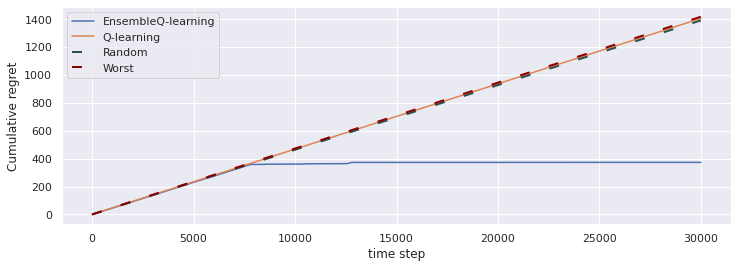

In [4]:
seed = 42
optimization_horizon = 30_000

# Instantiate the MDP
mdp = RiverSwimEpisodic(seed=0, p_rand=0.05, size=15)

# Instantiate the agent
ensemble_q_learning = EnsembleQLearning(
    seed=seed,
    mdp_specs=make_mdp_spec(mdp),
    optimization_horizon=optimization_horizon,
    n_ensembles=30,
    alpha=0.2,
)

# Perform the agent/MDP interaction
loop_ensemble = MDPLoop(mdp, ensemble_q_learning, logger=InMemoryLogger())
loop_ensemble.run(T=optimization_horizon, log_every=10)

# Q-learning agent with UCB exploration
q_learning_agent = QLearningEpisodic(
    mdp_specs=make_mdp_spec(mdp),
    seed=seed,
    optimization_horizon=optimization_horizon,
    c_1 = 0.95,
    p = 0.05
)
loop_ql = MDPLoop(mdp, q_learning_agent, logger=InMemoryLogger())
loop_ql.run(T=optimization_horizon, log_every=10)

# Plot the cumulative regret of the agents
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
loop_ensemble.plot(ax=ax, baselines=[])
loop_ql.plot(ax=ax)
plt.show()

### Benchmarking
````{margin}
```{hint}
For further details on running a {{col}} benchmark, have a look at the 
[_Benchmarks running_ tutorial](../tutorials/benchmark-running).
```
````

We now briefly benchmark the agent using the
[`EPISODIC_QUICK_TEST`](../pdoc_files/colosseum/benchmark/benchmark.html#ColosseumDefaultBenchmark.EPISODIC_QUICK_TEST) benchmark,
which is the default quick benchmark for the episodic setting.
Note that, for simplicity, the hyperparameters are sampled from the agent's hyparameter spaces, and no hyperparameters optimization is carried out.

In [5]:
# Register the EnsembleQLearning as it is not implemented in the Colosseum package
config.register_agent_class(EnsembleQLearning)

# Sample two random agent parameters
agents_configs = {
  EnsembleQLearning : sample_agent_gin_configs_file(EnsembleQLearning, n=2, seed=seed)
}

# Instantiate the benchmark
benchmark = ColosseumDefaultBenchmark.EPISODIC_QUICK_TEST.get_benchmark()

# Run the experiment instances
experiment_instances = instantiate_and_get_exp_instances_from_benchmark(agents_configs, benchmark)
run_experiment_instances(experiment_instances)

````{margin}
```{hint}
For further details on the analysis of the results of a benchmarking procedure, have a look at the 
[Benchmark analysis_ tutorial](../tutorials/benchmark-visualization).
```
````

The results of the benchmarking procedure are now stored locally and can be analysed.

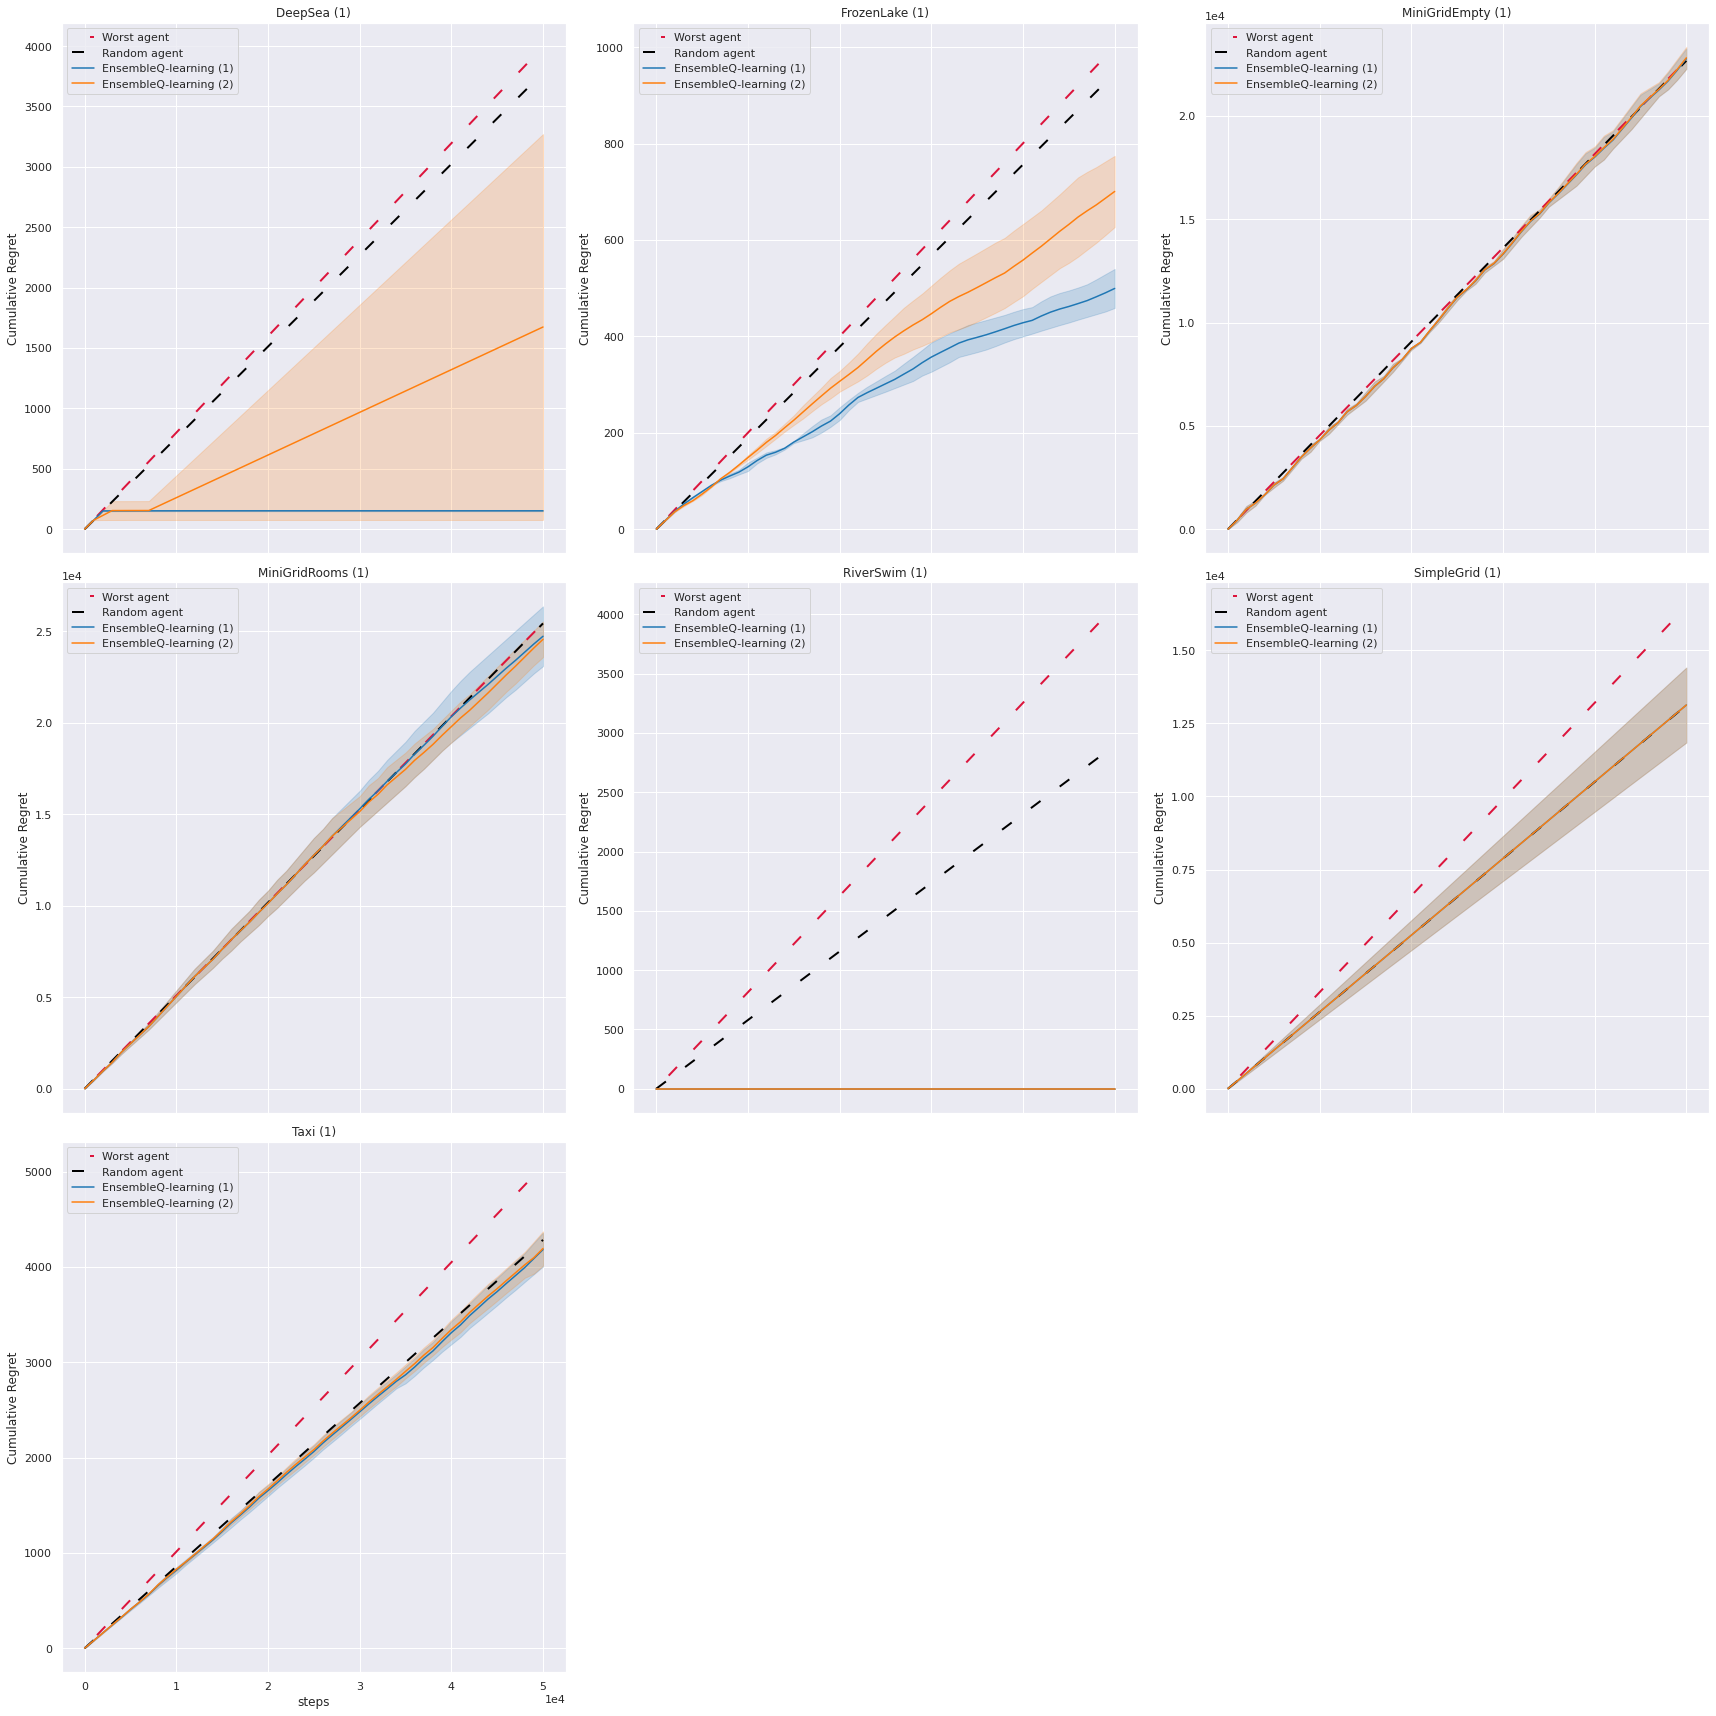

In [6]:
fig = agent_performances_per_mdp_plot(
    benchmark.get_experiments_benchmark_log_folder(),
    "cumulative_regret"
)

In [7]:
shutil.rmtree(config.get_experiments_folder())